# Project setup

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import gc

import tensorflow as tf

from sklearn.model_selection import train_test_split

from pycocotools.coco import COCO


import json
import requests
from io import BytesIO
from PIL import Image
import skimage.io as io

import os

import random
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

## Define all functions and utilz

In [21]:
# Garbage Collector - use it like gc.collect()
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [22]:
def display_image_with_bbox_from_url(image_info):
  loaded_image = io.imread(image_info['coco_url'])
  # load and display random image annotations
  plt.imshow(loaded_image)
  plt.axis('off')

  annotation_ids = coco.getAnnIds(imgIds=image_info['id'], iscrowd=None)
  annotations = coco.loadAnns(annotation_ids)

  bbx_annotations = []

  for entry in annotations:
    if entry['category_id'] not in CATEGORIES_IDS_NEEDED:
      continue

    bbx_annotations.append(entry)

  coco.showAnns(bbx_annotations, draw_bbox=True)



In [23]:
def display_image_from_url(url):
  loaded_image = io.imread(url)
  plt.axis('off')
  plt.imshow(loaded_image)
  plt.show()

In [24]:

def load_image_from_local(file_name):
  try:
    img_path = os.path.join(IMG_SAVE_DIR, file_name)
    image = Image.open(img_path)
  except:
    return None
  return image


In [25]:
def load_image_from_url(url):
  response = requests.get(url)
  image = Image.open(BytesIO(response.content))
  return image


In [26]:
def load_and_preprocess_image(image_info_param):
  target_width = 224
  target_height = 224

  image = load_image_from_local(image_info_param['file_name'])
  if image == None:
    image = load_image_from_url(image_info_param['coco_url'])

  image_resized = image.resize((target_width, target_height))

  image_resized_np = np.array(image_resized)
  image_normalized_resized = (image_resized_np - 127.5) / 127.5

  return image_normalized_resized


def preprocess_image(image):

  target_width = 224
  target_height = 224
  image_resized = image.resize((target_width, target_height))

  image_resized_np = np.array(image_resized)
  image_normalized_resized = (image_resized_np - 127.5) / 127.5

  return image_normalized_resized

In [27]:
def convert_categories_id_to_binary(classes_annotated, categories_needed, number_of_classes):
  class_labels = np.zeros(number_of_classes)

  for class_annotated_id in classes_annotated:
    if class_annotated_id in CATEGORIES_IDS_NEEDED:

      idx = CATEGORIES_IDS_NEEDED.index(class_annotated_id)
      if idx < number_of_classes:
        class_labels[idx] = 1
  return class_labels.tolist()

In [28]:

def generate_x_n_y(categories_needed, img_ids, number_of_classes):
  all_image_info = coco.loadImgs(img_ids)

  X_images = []
  y_labels = []

  for image_info in all_image_info:
    #print(len(all_image_info) - progress_counter)

    # load image and save
    image_loaded = load_and_preprocess_image(image_info)

    # skip black and white
    if image_loaded.shape == (224, 224):
      continue

    # get all uniq annotated classes
    annotated_categories = []
    image_annotations_ids = coco.getAnnIds(imgIds=[image_info['id']])
    annotations = coco.loadAnns(image_annotations_ids)

    for annotation in annotations:
      annotated_categories.append(annotation['category_id'])

    annotated_categories = list(dict.fromkeys(annotated_categories))

    annotated_catagories_hot = convert_categories_id_to_binary(annotated_categories,categories_needed,number_of_classes)

    #generate labe from annotated classes
    y_labels.append(annotated_catagories_hot)

    X_images.append(image_loaded)

  return np.array(X_images), np.array(y_labels)






In [29]:
def get_category_representation(y, number_of_categories_needed):
  classes_representet = np.zeros(number_of_categories_needed)
  for entry in y:
    print(entry)
    classes_representet+=entry
  return classes_representet

In [30]:
def plot_history(history):
    plt.figure()
    plt.title("Learning curves")
    plt.xlabel("Epoch")
    plt.ylabel("Cross entropy loss")
    plt.plot(history.history['loss'], label = 'train')
    plt.plot(history.history['val_loss'], label = 'valid')
    plt.legend()
    plt.show()

    plt.figure()
    plt.title("Learning curves")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(history.history['accuracy'], label = 'train')
    plt.plot(history.history['val_accuracy'], label = 'valid')
    plt.legend()
    plt.show()

# creating and testing a custom Convolutional neureal network

# Get data

In [4]:
annoations_file = "annotations/instances_train2017.json"

In [5]:
coco=COCO(annoations_file)

loading annotations into memory...
Done (t=19.81s)
creating index...
index created!


In [6]:
coco.info()

description: COCO 2017 Dataset
url: http://cocodataset.org
version: 1.0
year: 2017
contributor: COCO Consortium
date_created: 2017/09/01


In [31]:


# load all images in all nede categories
CATEGORIES_NEEDED=['toilet','oven','sink','refrigerator']


search_category_ids = coco.getCatIds(catNms=CATEGORIES_NEEDED);

img_ids_per_category_dict = {}
for category_id in search_category_ids:
  img_ids = coco.getImgIds(catIds=[category_id])
  category_info = coco.loadCats([category_id])[0]

  img_of_cat = []
  for img_id in img_ids:
    annotation_ids = coco.getAnnIds(imgIds=img_id, iscrowd=None)
    annotations = coco.loadAnns(annotation_ids)

    img_of_cat.append(img_id)

  img_ids_per_category_dict[category_info['name']] = img_of_cat
  print(f"Number of entries in category name: {category_info['name']} subcat: {category_info['supercategory']}  {len(img_of_cat)}")





Number of entries in category name: toilet subcat: furniture  3353
Number of entries in category name: oven subcat: appliance  2877
Number of entries in category name: sink subcat: appliance  4678
Number of entries in category name: refrigerator subcat: appliance  2360


In [32]:
def validate_by_amount_of_annotations(annotations, amount):
  if  len(annotations) > amount:
    return False
  return True

In [33]:
def validate_by_uniqe_category_id(annotations,current_category_id):
  for annotation in annotations:
      annotation_category_id = annotation['category_id']

      # just skip if annotation is same as current
      if current_category_id == annotation_category_id:
        continue

      # creating a copy of the list from needed categories ['toilet','oven','sink','refrigerator']
      # remove current, if current = sink, list = ['toilet','oven', 'refrigerator']
      # if annotation_id = toilet
      copy_id_list = CATEGORIES_IDS_NEEDED.copy()
      copy_id_list.remove(current_category_id)
      # if the annotation is still in the list, its invalid, like toilet
      if annotation_category_id in copy_id_list:
        return False
  return True


In [34]:


CATEGORIES_IDS_NEEDED = coco.getCatIds(catNms=CATEGORIES_NEEDED);
all_category_ids = coco.getCatIds()

sample_per_category = {'toilet': 400,
 'oven' : 400,
 'sink': 400,
'refrigerator':400}

sample_size = 500

# get all valid img ids
trainval_img_ids_in_categories = {}
# go through every image in every category
for category in CATEGORIES_NEEDED:
  viable_img_ids = []
  current_category_id =  coco.getCatIds(category)[0]
  is_valid = True
  for img_id in img_ids_per_category_dict[category]:

    # get all the annotations on the image
    annotation_ids = coco.getAnnIds(imgIds=img_id, iscrowd=None)
    annotations = coco.loadAnns(annotation_ids)
    # look through all the annotations, we only want pictures where there are no overlap in needed categories
    # Discard images containing both a sink and toilet
    is_valid = validate_by_uniqe_category_id(annotations, current_category_id)

    if is_valid:
      viable_img_ids.append(img_id)

  print(f"valid images in {category} {len(viable_img_ids)}")
  trainval_img_ids_in_categories[category] = viable_img_ids[:sample_per_category[category]]



valid images in toilet 1670
valid images in oven 1269
valid images in sink 1617
valid images in refrigerator 1115


In [35]:
for valid_imgs in trainval_img_ids_in_categories.values():
  print(len(valid_imgs))

400
400
400
400


In [36]:
#random.shuffle(all_img_ids)

In [37]:

# Specify where to save the images
IMG_SAVE_DIR = 'drive/MyDrive/coco_trainval'

# Download images

for category in trainval_img_ids_in_categories:
  print(category)
  img_ids = trainval_img_ids_in_categories[category]
  print(len(img_ids))
  img_infos = coco.loadImgs(img_ids)
  for img_info in img_infos:

    file_path = os.path.join(IMG_SAVE_DIR, img_info['file_name'])
    if os.path.exists(file_path):
      continue

    img_url = img_info['coco_url']
    img_data = requests.get(img_url).content
    with open(file_path, 'wb') as handler:
        handler.write(img_data)
  print("done")

toilet
400
done
oven
400
done
sink
400
done
refrigerator
400
done


In [38]:
TRAINVAL_IMG_IDS = []
for category in trainval_img_ids_in_categories:
  TRAINVAL_IMG_IDS.extend(trainval_img_ids_in_categories[category])

In [39]:
# select random image from image id list
random_img = coco.loadImgs(TRAINVAL_IMG_IDS[1600])[0]

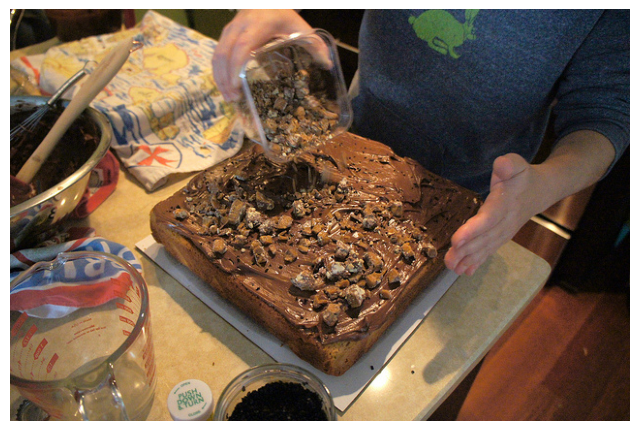

In [40]:
display_image_from_url(random_img['coco_url'])

[{'segmentation': [[214.9, 97.62, 220.65, 71.71, 215.86, 54.44, 209.14, 28.54, 211.06, 16.07, 223.53, 4.56, 638.94, 9.35, 622.63, 160.93, 471.05, 277.98, 450.9, 259.75, 470.09, 235.76, 507.51, 165.73, 453.78, 174.37, 350.17, 130.23, 285.89, 36.22, 233.13, 100.49, 206.26, 96.66]], 'area': 60520.56675, 'iscrowd': 0, 'image_id': 238140, 'bbox': [206.26, 4.56, 432.68, 273.42], 'category_id': 1, 'id': 529479}, {'segmentation': [[113.4, 257.86, 135.31, 275.96, 144.84, 303.6, 148.65, 348.39, 153.42, 390.31, 140.08, 420.81, 94.34, 420.81, 40.02, 420.81, 24.78, 412.23, 9.53, 394.13, 0.0, 388.41, 1.91, 279.78, 19.06, 264.53, 28.59, 260.72, 40.02, 260.72, 49.55, 253.09, 59.08, 250.24, 93.39, 250.24, 116.26, 255.95]], 'area': 22853.673549999996, 'iscrowd': 0, 'image_id': 238140, 'bbox': [0.0, 250.24, 153.42, 170.57], 'category_id': 47, 'id': 678809}, {'segmentation': [[213.93, 417.09, 220.62, 393.21, 224.44, 388.44, 239.72, 377.93, 245.45, 374.11, 260.73, 371.25, 286.52, 371.25, 295.11, 370.29, 30

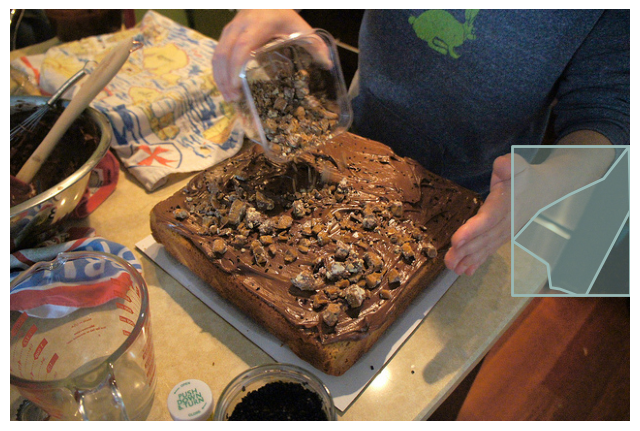

In [42]:
display_image_with_bbox_from_url(random_img)

# load and preprocess

# create model

In [27]:
def create_cnn_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=input_shape),
        tf.keras.layers.AveragePooling2D(),
        tf.keras.layers.Conv2D(64, 3, activation='relu'),
        tf.keras.layers.AveragePooling2D(),
        tf.keras.layers.Conv2D(128, 3, activation='relu'),
        tf.keras.layers.AveragePooling2D(),
        tf.keras.layers.Flatten(),

        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model



In [28]:


def create_cnn_model(input_shape, num_classes):
  cnn = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=input_shape, kernel_regularizer=regularizers.l2(l=0.01)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(l=0.01)),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes)
  ])

  return cnn



In [43]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",input_shape=(224,224,3)),
  ]
)

def create_cnn_model(input_shape, num_classes):
  model = tf.keras.models.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(16, 3, activation='relu',input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(64, 3, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='sigmoid')
  ])
  return model

In [44]:
X,y = generate_x_n_y(CATEGORIES_NEEDED, TRAINVAL_IMG_IDS,len(CATEGORIES_NEEDED))

In [45]:
y

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

In [46]:
print(f"x shape {X.shape}")
print(f"y shape {y.shape}")


x shape (1600, 224, 224, 3)
y shape (1600, 4)


In [47]:
# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42)


In [ ]:
X_train

In [ ]:
y_train

In [ ]:
y_val

# train model

In [49]:
# setup models and train


epochs = 100
learning_rate = 0.001
shape = X_train[0].shape

# create models
cnn_model = create_cnn_model(shape, len(CATEGORIES_NEEDED))

optimizer = tf.keras.optimizers.AdamW(learning_rate = learning_rate)
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=False)
metrics = tf.keras.metrics.CategoricalAccuracy(name="accuracy")

cnn_model.compile(loss = loss_function, optimizer = optimizer, metrics = metrics)
#cnn_model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), metrics = metrics)
#cnn_model.compile(loss = loss_function, optimizer = 'adam', metrics = ['accuracy'])

cnn_model.build(shape)

cnn_model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 20, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, min_lr=0.00000001)
garbage_collection = GarbageCollectorCallback()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 16)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                

In [59]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [57]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

In [60]:
# train models
with tf.device('/CPU:0'):
    history_cnn_model = cnn_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), callbacks=[early_stop,garbage_collection])

plot_history(history=history_cnn_model)

Epoch 1/100
40/40 [==============================] - 11s 252ms/step - loss: 0.5414 - accuracy: 0.4109 - val_loss: 0.5713 - val_accuracy: 0.3344
Epoch 2/100
40/40 [==============================] - 10s 241ms/step - loss: 0.5361 - accuracy: 0.4227 - val_loss: 0.5403 - val_accuracy: 0.4125
Epoch 3/100
 9/40 [=====>........................] - ETA: 7s - loss: 0.5301 - accuracy: 0.4410

KeyboardInterrupt: 

In [52]:
cnn_model.get_metrics_result()

{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.5591545>,
 'accuracy': <tf.Tensor: shape=(), dtype=float32, numpy=0.33125>}

In [53]:
test_img_urls = ["https://www.ikea.com/us/en/images/products/hillesjoen-double-bowl-top-mount-sink-stainless-steel__0867462_pe585221_s5.jpg","https://www.kraususa.com/media/wysiwyg/Kitchen_Sinks_undermount.jpg","https://assets.cdnlemu.dk/api/sitecore/asset/get?id=c6288339-aa39-4967-8706-7d5664982807&size=SocialMediaThumbnail"]

predict_images = []
for url in test_img_urls:
  response = requests.get(url) # https://www.badstil.dk/images/avente/484/spazio-lft-18-toiletter-hvid-bad-stil-s-01-p.jpg
  image = Image.open(BytesIO(response.content))

  image = image.resize((224, 224))
  image = np.array(image)

  predict_images.append(image)


pedict_images_np = np.array(predict_images)

print(pedict_images_np.shape)
predictions = cnn_model.predict(pedict_images_np)
print(predictions)

for i, prediction in enumerate(predictions):
  for j, value in enumerate(prediction):
    print(f"{CATEGORIES_NEEDED[j]}: {value*100}")
  print()


(3, 224, 224, 3)
1/1 [==============================] - 0s 325ms/step
[[0.0000000e+00 1.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 1.0000000e+00 1.6720239e-29 1.0335184e-18]
 [0.0000000e+00 1.0000000e+00 5.3612767e-13 4.4881629e-12]]
toilet: 0.0
oven: 100.0
sink: 0.0
refrigerator: 0.0

toilet: 0.0
oven: 100.0
sink: 1.6720239169260063e-27
refrigerator: 1.0335184382101193e-16

toilet: 0.0
oven: 100.0
sink: 5.361276743734433e-11
refrigerator: 4.488162879540125e-10



In [48]:
#undeclare non-needed variables
cnn_model = None
X = None
y = None
coco = None
history_cnn_model = None
img_ids_per_category_dict = None

gc.collect()

2131